In [1]:
import numpy as np 
import pandas as pd 
import os
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### 1. Data Extraction

In [2]:
encoding = 'ISO-8859-1'
col_names = ['Sentiment', 'Twtter_Id', 'Date', 'Flag', 'UserName', 'Tweet']

#Non-Depressive Tweets
dataset = pd.read_csv('/kaggle/input/sentimental-analysis/training.1600000.processed.noemoticon.csv', encoding=encoding, names=col_names)
dataset = dataset[dataset['Sentiment'] == 4]
dataset = dataset[['Tweet','Sentiment']]
dataset['Sentiment'].replace(4, 0, inplace=True)
dataset = dataset.sample(15000, random_state=42)

#0 - POSITIVE TWEETS

In [3]:
dataset1 = pd.read_csv("/kaggle/input/sentimental-analysis/Mental-Health-Twitter.csv",encoding=encoding)
dataset1.rename(columns={'post_text': 'Tweet', 'label': 'Sentiment'}, inplace=True)
dataset1 = dataset1[dataset1['Sentiment'] == 1]
dataset1 = dataset1[['Tweet','Sentiment']]
col_names = ['UserName','Tweet']
dataset2 = pd.read_csv('/kaggle/input/sentimental-analysis/depressive_tweets_processed.csv', sep = '|', header = None, usecols = [4,5], nrows = 3200, names=col_names)
dataset2['Sentiment'] = 1;
dataset2 = dataset2[['Tweet','Sentiment']]


In [4]:
dataset1 = pd.concat([dataset1,dataset2])
dataset1 = dataset1.sample(frac = 1)
dataset1.reset_index(drop=True, inplace=True)
dataset = pd.concat([dataset,dataset1])
dataset = dataset.sample(frac = 1)
dataset.reset_index(drop=True, inplace=True)

In [5]:
df = dataset.copy()
df.reset_index(drop=True, inplace=True)
df.isnull()
df.dropna(inplace=True)
df.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [6]:
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 2. Data Preprocessing

In [7]:
import spacy

# Load the English language model
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    # Process the text with SpaCy
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc]
    return ' '.join(lemmatized_tokens)



In [8]:
import re
import string
import pandas as pd
import emoji
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}


def text_transformation(text):
    if isinstance(text, str):
        text = text.lower() #LOWER CASE
        text = emoji.demojize(text)
        text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])  
        text = re.sub('\[.*?\]', '', text) #REMOVES BRACKETS AND BTW THEM
        text = re.sub("\\W"," ",text) #REMOVES NON-WORDS
        text = re.sub('https?://\S+|www\.\S+', '', text) #REMOVES LINKS
        text = re.sub('<.*?>+', '', text) #REMOVES HTML TAGS
        text = re.sub('[%s]' % re.escape(string.punctuation), '', text) #REMOVES PUNCUTATIONS
        text = re.sub('\n', '', text) #REMOVES NEW LINES
        text = re.sub('\w*\d\w*', '', text)  #REMOVES ALPHA NUMERICAL  
        text = re.sub(' +', ' ', text)  # Replace multiple spaces with a single space
    return text

df["Tweet"] = df["Tweet"].apply(text_transformation)



In [9]:
import nltk
from nltk.corpus import stopwords

# Define a custom list of generalized stopwords
generalized_stopwords = [
    'i','' 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves',
    'you', 'your', 'yours', 'yourself', 'yourselves','go',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
    'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
    'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those',
    'a', 'an', 'at','the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
    'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to',
    'from', 'up', 'down', 'in', 'out', 'im','on', 'off', 'over', 'under', 'again',
    'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how',
    'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some',
    'such','only', 'own', 'same', 'so', 'than', 'too','https','twitter','tweet',
]


df["Tweet"] = df["Tweet"].apply(lambda x: " ".join(x for x in x.split() if x not in generalized_stopwords))
df["Tweet"] = df["Tweet"].apply(lemmatize_text)


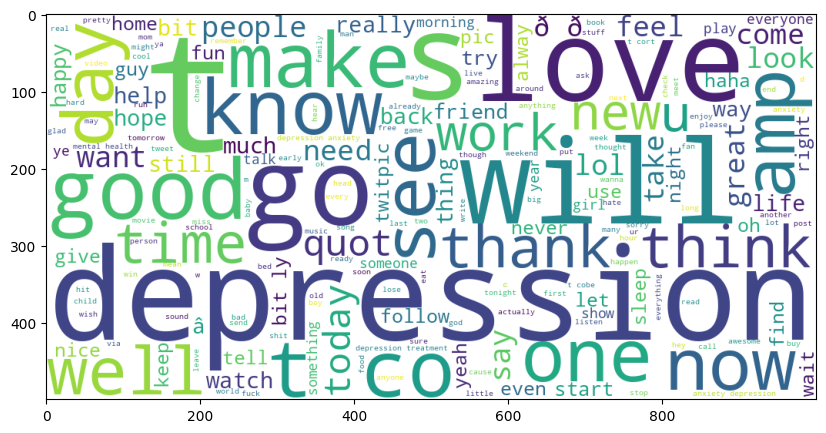

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

word_cloud = ""
for row in df['Tweet']:
    for word in row:
        word_cloud += " ".join(word)

wordcloud = WordCloud(width=1000, height=500, background_color='white', min_font_size=6).generate(word_cloud)
fig, ax = plt.subplots(figsize=(10, 5))
# Define the rectangle patch
rect = Rectangle((0.1, 0.1), 0.5, 0.3, linewidth=1, edgecolor='r', facecolor='none')
# Add the rectangle patch to the plot
ax.add_patch(rect)
plt.imshow(wordcloud)
plt.show()


In [11]:
!pip install textblob
# Lemmatization (to group similar words together)
nltk.download("wordnet")
nltk.download("omw-1.4")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.0 MB/s eta 0:00:0000:010:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

### 3. Feature Extraction and Model Building

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from gensim.models import Word2Vec
import nltk
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.tree import DecisionTreeClassifier

def performance_eval(clf, X_test, y_test):
    y_pred = clf.predict(X_test)

    print(f'Accuracy: {accuracy_score(y_test, y_pred)}\n')
    
    print('   ------------ Classification Report -----------')
    print(classification_report(y_test, y_pred))
    
    print('   ------------ Confusion Matrix -------------- ')
    cm = confusion_matrix(y_test, y_pred)
    
    sns.set(rc={'figure.figsize':(10,6)})
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,cmap = "Blues",fmt='d', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
    plt.text(0.5, 0.4, f'True Negative ', ha='center', va='center',color='white')
    plt.text(0.5, 1.4, f'False Positive ', ha='center', va='center')
    plt.text(1.5, 0.4, f'False Negative ', ha='center', va='center')
    plt.text(1.5, 1.4, f'True Positive ', ha='center', va='center',color='white')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

#    1. LOGISTIC REGRESSION

###         • Using Bag Of Words (CountVectorizer)

Logistic Regression (BOW)

Accuracy: 0.9022515101592532

   ------------ Classification Report -----------
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3069
           1       0.94      0.82      0.88      2394

    accuracy                           0.90      5463
   macro avg       0.91      0.89      0.90      5463
weighted avg       0.91      0.90      0.90      5463

   ------------ Confusion Matrix -------------- 


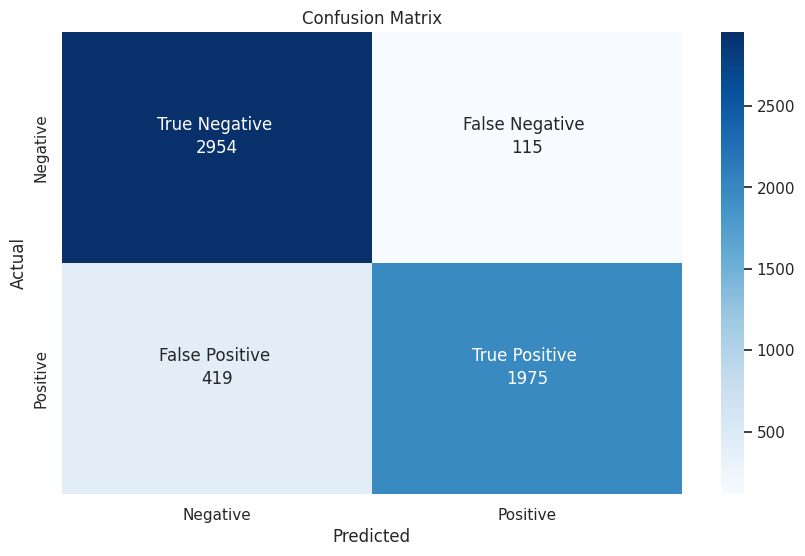

In [13]:
X = df['Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Logistic Regression (BOW)\n")
performance_eval(lr,X_test,y_test)


###         • Using TF-IDF

Logistic Regression (TF-IDF)

Accuracy: 0.8918176825919825

   ------------ Classification Report -----------
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      3069
           1       0.95      0.80      0.87      2394

    accuracy                           0.89      5463
   macro avg       0.90      0.88      0.89      5463
weighted avg       0.90      0.89      0.89      5463

   ------------ Confusion Matrix -------------- 


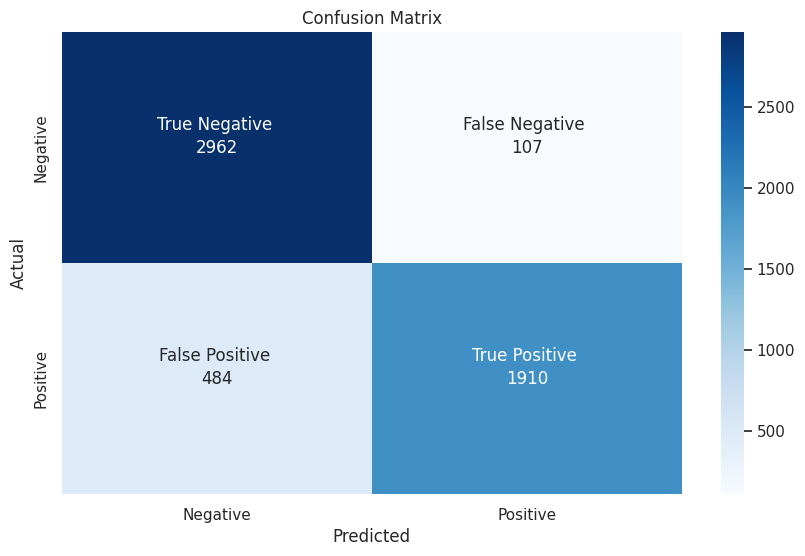

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
print("Logistic Regression (TF-IDF)\n")
performance_eval(lr,X_test_tfidf,y_test)

#    2. DECISION TREE

###         • Using Bag Of Words (CountVectorizer)

Decision Tree (BOW)

Accuracy: 0.8312282628592349

   ------------ Classification Report -----------
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      3069
           1       0.80      0.82      0.81      2394

    accuracy                           0.83      5463
   macro avg       0.83      0.83      0.83      5463
weighted avg       0.83      0.83      0.83      5463

   ------------ Confusion Matrix -------------- 


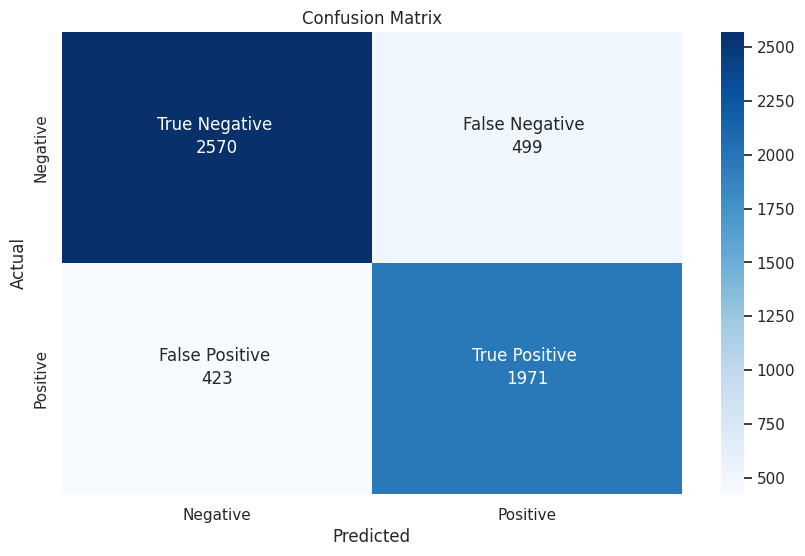

In [15]:
X = df['Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
print("Decision Tree (BOW)\n")
performance_eval(dt_classifier,X_test,y_test)

###         • Using TF-IDF

Decision Tree (TF-IDF)

Accuracy: 0.8184147904082006

   ------------ Classification Report -----------
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      3069
           1       0.78      0.82      0.80      2394

    accuracy                           0.82      5463
   macro avg       0.82      0.82      0.82      5463
weighted avg       0.82      0.82      0.82      5463

   ------------ Confusion Matrix -------------- 


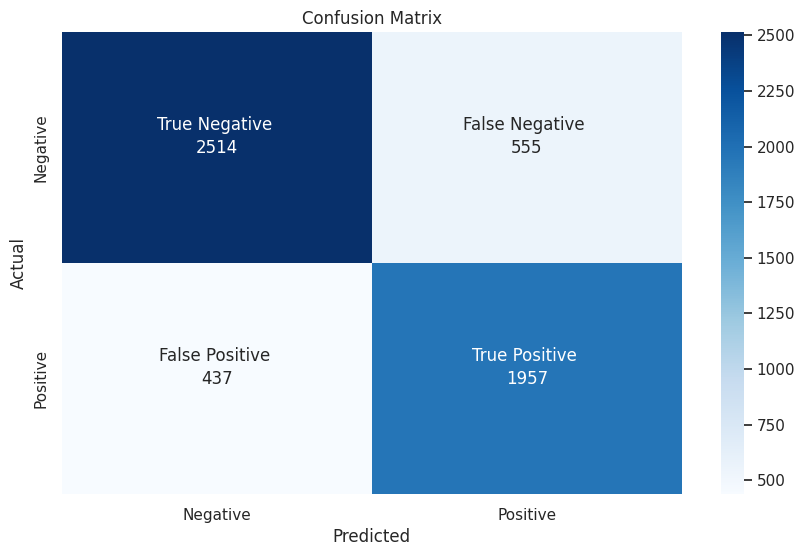

In [16]:
X = df['Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_tfidf, y_train)
print("Decision Tree (TF-IDF)\n")
performance_eval(dt_classifier,X_test_tfidf,y_test)


#    3. RANDOM FOREST

Random Forest (BOW)

Accuracy: 0.8744279699798645

   ------------ Classification Report -----------
              precision    recall  f1-score   support

           0       0.86      0.93      0.89      3069
           1       0.89      0.81      0.85      2394

    accuracy                           0.87      5463
   macro avg       0.88      0.87      0.87      5463
weighted avg       0.88      0.87      0.87      5463

   ------------ Confusion Matrix -------------- 


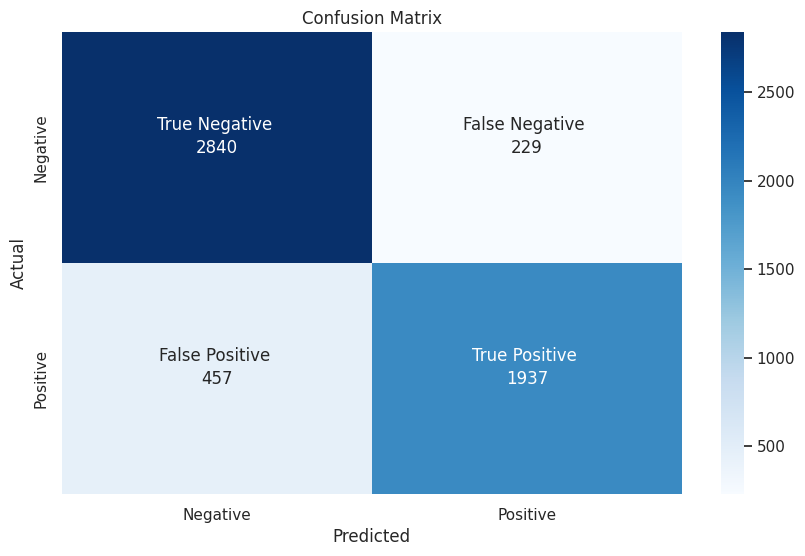

In [17]:
X = df['Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer()
X_train = count_vectorizer.fit_transform(X_train)
X_test = count_vectorizer.transform(X_test)
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
print("Random Forest (BOW)\n")
performance_eval(rf_classifier,X_test,y_test)

###         • Using TF-IDF

Random Forest (TF-IDF)

Accuracy: 0.8639941424125938

   ------------ Classification Report -----------
              precision    recall  f1-score   support

           0       0.85      0.93      0.88      3069
           1       0.89      0.78      0.83      2394

    accuracy                           0.86      5463
   macro avg       0.87      0.86      0.86      5463
weighted avg       0.87      0.86      0.86      5463

   ------------ Confusion Matrix -------------- 


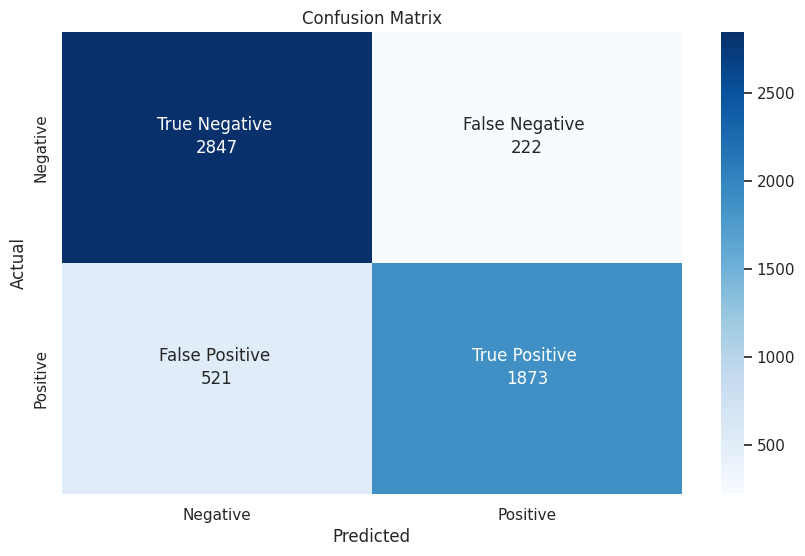

In [18]:
X = df['Tweet']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_tfidf, y_train)
print("Random Forest (TF-IDF)\n")
performance_eval(rf_classifier,X_test_tfidf,y_test)


In [19]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.4 MB/s eta 0:00:0000:010:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
Note: you may need to restart the kernel to use updated packages.


## 4. LSTM Model

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame with columns 'Tweet' and 'Sentiment'
X = df['Tweet']
y = df['Sentiment']

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences to have consistent length
X_padded = pad_sequences(X_seq)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Build the LSTM model
embedding_dim = 200
max_length = X_padded.shape[1]

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(100))  # You can adjust the number of LSTM units
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'LSTM Model Accuracy: {accuracy}')


LSTM Model Acuracy: 0.913683


In [21]:
pip install deap


Note: you may need to restart the kernel to use updated packages.


## 5. DEAP WITH LOGISTIC REGRESSION

In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  # Import logistic regression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from deap import base, creator, tools, algorithms
import random

# Assume df is your dataframe with columns 'Tweet' and 'Sentiment'

# Feature extraction using Bag of Words
vectorizer = CountVectorizer(max_features=1000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['Tweet']).toarray()
y = df['Sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define genetic algorithm parameters
population_size = 1000
num_generations = 50
crossover_prob = 0.7
mutation_prob = 0.6

# Create a fitness function
def evaluate(individual, X_train, y_train, X_test, y_test):
    selected_features = [bool(bit) for bit in individual]
    clf = LogisticRegression(random_state=42)  # Use logistic regression
    clf.fit(X_train[:, selected_features], y_train)
    y_pred = clf.predict(X_test[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    #print(f'Accuracy: {accuracy}\n')
    return accuracy,

# Define genetic algorithm parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X[0]))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

# Initialize population
population = toolbox.population(n=population_size)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=num_generations, stats=None, halloffame=None,verbose = 0)

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]
selected_features = [bool(bit) for bit in best_individual]

# Use the selected features in your model
final_X_train = X_train[:, selected_features]
final_X_test = X_test[:, selected_features]

# Train your model using the selected features
clf = LogisticRegression(random_state=42)  # Use logistic regression
clf.fit(final_X_train, y_train)

y_pred = clf.predict(final_X_test)
print(f'DEAP with Logistic Regression \nAccuracy: {accuracy_score(y_test, y_pred)}\n')


DEAP with Logistic Regression 
Accuracy: 0.9056474457



## 6. DEAP WITH DECISION TREE

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from deap import base, creator, tools, algorithms
import random

# Assume df is your dataframe with columns 'Tweet' and 'Sentiment'

# Feature extraction using Bag of Words
vectorizer = CountVectorizer(max_features=1000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['Tweet']).toarray()
y = df['Sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define genetic algorithm parameters
population_size = 1000
num_generations = 50
crossover_prob = 0.7
mutation_prob = 0.6

# Create a fitness function
def evaluate(individual, X_train, y_train, X_test, y_test):
    selected_features = [bool(bit) for bit in individual]
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train[:, selected_features], y_train)
    y_pred = clf.predict(X_test[:, selected_features])
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy,

# Define genetic algorithm parameters
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(X[0]))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=5)

# Initialize population
population = toolbox.population(n=population_size)

# Run the genetic algorithm
algorithms.eaSimple(population, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=num_generations, stats=None, halloffame=None)

# Get the best individual
best_individual = tools.selBest(population, k=1)[0]
selected_features = [bool(bit) for bit in best_individual]

# Use the selected features in your model
final_X_train = X_train[:, selected_features]
final_X_test = X_test[:, selected_features]

# Train your model using the selected features
clf = DecisionTreeClassifier(random_state=42)
clf.fit(final_X_train, y_train)

y_pred_final = final_model.predict(final_X_test)
accuracy_final = accuracy_score(y_test, y_pred_final)
print("DEAP with Decision Tree \nAccuracy: ", accuracy_final)


DEAP with Decision Tree 
Accuracy: 0.873534546



In [24]:
#pip install tqdm


## 7 . SIMPLE GA WITH LOGISTIC REGRESSION

In [25]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
# Define your dataset and labels
X = df["Tweet"].values
y = df["Sentiment"].values

# Use CountVectorizer for text to convert it into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

# Define the parameters
population_size = 1000
num_generations = 50
crossover_prob = 0.7
mutation_prob = 0.6

# Define the classifier
clf = LogisticRegression()

# Function to initialize the population
def initialize_population():
    return np.random.choice([0, 1], size=(population_size, X.shape[1]))


# Function to evaluate the fitness of each individual
def evaluate_fitness(population):
    accuracies = []
    for features in population:
        selected_features = np.where(features == 1)[0]
        
        # Use selected features for training
        X_train, X_test, y_train, y_test = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return np.array(accuracies)

# Function to perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Function to perform mutation
def mutate(individual):
    mutation_points = np.random.rand(len(individual)) < mutation_prob
    individual[mutation_points] = 1 - individual[mutation_points]
    return individual

# Main genetic algorithm loop
population = initialize_population()
for generation in range(num_generations):
    fitness_values = evaluate_fitness(population)
    
    # Select top individuals based on fitness
    selected_indices = np.argsort(fitness_values)[::-1][:int(population_size * 0.2)]
    selected_population = population[selected_indices]
    
    # Create new population through crossover and mutation
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = selected_population[np.random.choice(len(selected_population), size=2, replace=False)]
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.extend([child1, child2])
    
    population = np.array(new_population)

# Select the best individual from the final population
best_individual = population[np.argmax(evaluate_fitness(population))]

# Use the selected features for training the final model
selected_features = np.where(best_individual == 1)[0]
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)
final_model = LogisticRegression()
final_model.fit(X_train_final, y_train_final)

# Evaluate the final model
y_pred_final = final_model.predict(X_test_final)
accuracy_final = accuracy_score(y_test_final, y_pred_final)
print("Scratch GA with Logistic Regression \nAccuracy: ", accuracy_final)


Scratch GA with Logistic Regression 
Accuracy: 0.91346533



## 8. SIMPLE GA WITH DECISION TREE

In [26]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define your dataset and labels
X = df["Tweet"].values
y = df["Sentiment"].values

# Use CountVectorizer for text to convert it into a bag-of-words representation
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

# Define the parameters
population_size = 1000
num_generations = 50
crossover_prob = 0.7
mutation_prob = 0.6

# Define the classifier
clf = DecisionTreeClassifier()

# Function to initialize the population
def initialize_population():
    return np.random.choice([0, 1], size=(population_size, X.shape[1]))


# Function to evaluate the fitness of each individual
def evaluate_fitness(population):
    accuracies = []
    for features in population:
        selected_features = np.where(features == 1)[0]
        
        # Use selected features for training
        X_train, X_test, y_train, y_test = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return np.array(accuracies)

# Function to perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Function to perform mutation
def mutate(individual):
    mutation_points = np.random.rand(len(individual)) < mutation_prob
    individual[mutation_points] = 1 - individual[mutation_points]
    return individual

# Main genetic algorithm loop
population = initialize_population()
for generation in range(num_generations):
    fitness_values = evaluate_fitness(population)
    
    # Select top individuals based on fitness
    selected_indices = np.argsort(fitness_values)[::-1][:int(population_size * 0.2)]
    selected_population = population[selected_indices]
    
    # Create new population through crossover and mutation
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = selected_population[np.random.choice(len(selected_population), size=2, replace=False)]
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.extend([child1, child2])
    
    population = np.array(new_population)

# Select the best individual from the final population
best_individual = population[np.argmax(evaluate_fitness(population))]

# Use the selected features for training the final model
selected_features = np.where(best_individual == 1)[0]
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)
final_model = DecisionTreeClassifier()
final_model.fit(X_train_final, y_train_final)

# Evaluate the final model
y_pred_final = final_model.predict(X_test_final)
accuracy_final = accuracy_score(y_test_final, y_pred_final)
print("Scratch GA with Decision Tree \nAccuracy: ", accuracy_final)


Scratch GA with Decision Tree 
Accuracy: 0.883590436



## 9. SIMPLE GA WITH RANDOMFOREST

In [27]:
import pandas as pd
import numpy as np
from Dsklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import random

# Assume df is your dataframe with columns 'Tweet' and 'Sentiment'

# Feature extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X = vectorizer.fit_transform(df['Tweet']).toarray()
y = df['Sentiment']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameters
population_size = 1000
num_generations = 50
crossover_prob = 0.7
mutation_prob = 0.6

# Function to initialize the population
def initialize_population():
    return np.random.choice([0, 1], size=(population_size, X.shape[1]))

# Function to evaluate the fitness of each individual
def evaluate_fitness(population):
    accuracies = []
    for features in population:
        selected_features = np.where(features == 1)[0]
        
        # Use selected features for training
        X_train, X_test, y_train, y_test = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)
        
        clf = RandomForestClassifier(random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)
    
    return np.array(accuracies)

# Function to perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Function to perform mutation
def mutate(individual):
    mutation_points = np.random.rand(len(individual)) < mutation_prob
    individual[mutation_points] = 1 - individual[mutation_points]
    return individual

# Main genetic algorithm loop
population = initialize_population()
for generation in range(num_generations):
    fitness_values = evaluate_fitness(population)
    
    # Select top individuals based on fitness
    selected_indices = np.argsort(fitness_values)[::-1][:int(population_size * 0.2)]
    selected_population = population[selected_indices]
    
    # Create new population through crossover and mutation
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = selected_population[np.random.choice(len(selected_population), size=2, replace=False)]
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.extend([child1, child2])
    
    population = np.array(new_population)

# Select the best individual from the final population
best_individual = population[np.argmax(evaluate_fitness(population))]

# Use the selected features for training the final model
selected_features = np.where(best_individual == 1)[0]
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(X[:, selected_features], y, test_size=0.2, random_state=42)

# Try a Random Forest as the final model
final_model = RandomForestClassifier(random_state=42)
final_model.fit(X_train_final, y_train_final)

# Evaluate the final model
y_pred_final = final_model.predict(X_test_final)
accuracy_final = accuracy_score(y_test_final, y_pred_final)
print("Scratch GA with RandomForest\nAccuracy: ", accuracy_final)


Scratch GA with RandomForest
Accuracy: 0.89325934



## 10. GA WITH LSTM

In [28]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Assuming df is your DataFrame with columns 'Tweet' and 'Sentiment'
X = df['Tweet']
y = df['Sentiment']

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

# Pad sequences to have consistent length
X_padded = pad_sequences(X_seq)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Define the parameters for the genetic algorithm
population_size = 1000
num_generations = 50
crossover_prob = 0.7
mutation_prob = 0.6

# Define the embedding dimension
embedding_dim = 200  # You can adjust this value as needed

# Function to initialize the population
def initialize_population(population_size, num_features):
    return np.random.choice([0, 1], size=(population_size, num_features))

# Function to evaluate the fitness of each individual
def evaluate_fitness(population):
    accuracies = []
    for features in population:
        selected_features = np.where(features == 1)[0]
        X_train_selected = X_train[:, selected_features]
        X_test_selected = X_test[:, selected_features]
        
        # Build and train the LSTM model
        model = Sequential()
        model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim))
        model.add(LSTM(100))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        model.fit(X_train_selected, y_train, epochs=10, batch_size=32, validation_data=(X_test_selected, y_test), verbose=0)
        
        # Evaluate the model
        _, accuracy = model.evaluate(X_test_selected, y_test)
        accuracies.append(accuracy)
    
    return np.array(accuracies)

# Function to perform crossover
def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, len(parent1))
    child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
    return child1, child2

# Function to perform mutation
def mutate(individual):
    mutation_points = np.random.rand(len(individual)) < mutation_prob
    individual[mutation_points] = 1 - individual[mutation_points]
    return individual

# Initialize population
population = initialize_population(population_size, X_padded.shape[1])

# Main genetic algorithm loop
for generation in range(num_generations):
    fitness_values = evaluate_fitness(population)
    
    # Select top individuals based on fitness
    selected_indices = np.argsort(fitness_values)[::-1][:int(population_size * 0.2)]
    selected_population = population[selected_indices]
    
    # Create new population through crossover and mutation
    new_population = []
    for _ in range(population_size // 2):
        parent1, parent2 = selected_population[np.random.choice(len(selected_population), size=2, replace=False)]
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        new_population.extend([child1, child2])
    
    population = np.array(new_population)

# Select the best individual from the final population
best_individual = population[np.argmax(evaluate_fitness(population))]

# Use the selected features for training the final model
selected_features = np.where(best_individual == 1)[0]
X_train_selected = X_train[:, selected_features]
X_test_selected = X_test[:, selected_features]

# Build and train the final LSTM model
final_model = Sequential()
final_model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim))
final_model.add(LSTM(100))
final_model.add(Dense(1, activation='sigmoid'))
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
final_model.fit(X_train_selected, y_train, epochs=5, batch_size=32, validation_data=(X_test_selected, y_test), verbose=0)

# Evaluate the final model
loss, accuracy = final_model.evaluate(X_test_selected, y_test, verbose=0)
print(f'GA with LSTM Model Accuracy: {accuracy}')


GA with LSTM Model Accuracy: 0.9304923
